<a href="https://colab.research.google.com/github/vpcano/CAP_P2/blob/main/Ej1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p cuda
!rm -rf cuda/*

In [ ]:
%%writefile cuda/stencil_1d_cpu.cu
    #include <iostream>
    #include <algorithm>
    #include <sys/time.h>
    using namespace std;

    #define RADIUS 3

    void stencil_1D(int *in, int *out, int N) {
        for (int i=0; i<N; i++) {
            out[i] = 0;
            for (int offset=-RADIUS; offset<=RADIUS; offset++) {
                out[i] += in[i+offset];
            }
        }
    }


    void fill_ints(int *x, int n) {
        fill_n(x, n, 1);
    }

    int main(int argc, char *argv[]) {
        int *in, *out;
        int N, size;
        struct timeval t1, t2;
        double t_total;

        if (argc < 2) {
            printf("Error: you must indicate the length of the array\n");
            return 1;
        }

        N = atoi(argv[1]);
        size = (N + 2*RADIUS) * sizeof(int);

        in = (int*) malloc(size);
        out = (int*) malloc(size);
        fill_ints(in, N + 2*RADIUS);
        fill_ints(out, N + 2*RADIUS);

        gettimeofday(&t1, NULL);
        stencil_1D(in + RADIUS, out + RADIUS, N);
        gettimeofday(&t2, NULL);

        /*
        printf("Output: \n");
        for (int i=0; i<N+2*RADIUS; i++) {
            printf("%d ", out[i]);
        }
        printf("\n");
        */
        t_total = (t2.tv_sec - t1.tv_sec)*1000000.0 + (t2.tv_usec - t1.tv_usec);
        printf("%d\t%f\n", N, t_total);

        free(in);
        free(out);
        return 0;
    }

Writing cuda/stencil_1d_cpu.cu


In [ ]:
!nvcc cuda/stencil_1d_cpu.cu -o cuda/stencil_1d_cpu
!./cuda/stencil_1d_cpu 10000000


10000000	334575.000000


In [ ]:
%%writefile cuda/stencil_1d_gpu.cu
    #include <iostream>
    #include <algorithm>
    #include <sys/time.h>
    #include "cuda.h"
    #include "cuda_runtime.h"
    using namespace std;

    #define RADIUS 3
    #define BLOCK_SIZE 16

    __global__ void stencil_1D(int *in, int *out, int N) {
        __shared__ int temp[BLOCK_SIZE + 2*RADIUS];
        int gindex = threadIdx.x + blockIdx.x*blockDim.x;
        int lindex = threadIdx.x + RADIUS;
        int n_blocks;

        if (blockIdx.x == gridDim.x-1 && N % BLOCK_SIZE != 0) {
            n_blocks = N % BLOCK_SIZE;
        }
        else {
            n_blocks = BLOCK_SIZE;
        }

        if (threadIdx.x < RADIUS) {
            temp[lindex - RADIUS] = in[gindex - RADIUS];
            temp[lindex + n_blocks] = in[gindex + n_blocks];
        }

        if (threadIdx.x < n_blocks) {
            temp[lindex] = in[gindex];

            __syncthreads();

            int result = 0;
            for (int offset=-RADIUS; offset<=RADIUS; offset++) {
                result += temp[lindex + offset];
            }

            out[gindex] = result;
        }
    }


    void fill_ints(int *x, int n) {
        fill_n(x, n, 1);
    }

    int main(int argc, char *argv[]) {
        int *h_in, *h_out;
        int *d_in, *d_out;
        int N, size;
        struct timeval t1, t2;
        double t_total;

        if (argc < 2) {
            printf("Error: you must indicate the length of the array\n");
            return 1;
        }

        N = atoi(argv[1]);
        size = (N + 2*RADIUS) * sizeof(int);

        h_in = (int*) malloc(size);
        h_out = (int*) malloc(size);
        fill_ints(h_in, N + 2*RADIUS);
        fill_ints(h_out, N + 2*RADIUS);



        cudaMalloc((void**) &d_in, size);
        cudaMalloc((void**) &d_out, size);

        gettimeofday(&t1, NULL);
        cudaMemcpy(d_in, h_in, size, cudaMemcpyHostToDevice);
        cudaMemcpy(d_out, h_out, size, cudaMemcpyHostToDevice);

        stencil_1D<<<(N+BLOCK_SIZE-1)/BLOCK_SIZE,BLOCK_SIZE>>>(d_in + RADIUS, d_out + RADIUS, N);

        cudaMemcpy(h_out, d_out, size, cudaMemcpyDeviceToHost);

        gettimeofday(&t2, NULL);

        /*
        printf("Output: \n");
        for (int i=0; i<N+2*RADIUS; i++) {
            printf("%d ", h_out[i]);
        }
        printf("\n");
        */
        t_total = (t2.tv_sec - t1.tv_sec)*1000000.0 + (t2.tv_usec - t1.tv_usec);
        printf("%d\t%f\n", N, t_total);

        free(h_in);
        free(h_out);
        cudaFree(d_in);
        cudaFree(d_out);
        return 0;
    }

Overwriting cuda/stencil_1d_gpu.cu


In [ ]:
!nvcc cuda/stencil_1d_gpu.cu -o cuda/stencil_1d_gpu
!./cuda/stencil_1d_gpu 10000000


10000000	125402.000000


In [ ]:
!nvcc cuda/stencil_1d_cpu.cu -o cuda/stencil_1d_cpu
!nvcc cuda/stencil_1d_gpu.cu -o cuda/stencil_1d_gpu

In [ ]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

tam_ini = 10**5
tam_fin = 10**6

N = tam_ini
data= list()
speedup = list()

while N <= tam_fin:

    result_cpu = subprocess.run(["./cuda/stencil_1d_cpu" , str(N)], stdout=subprocess.PIPE, text=True)
    result_gpu = subprocess.run(["./cuda/stencil_1d_gpu" , str(N)], stdout=subprocess.PIPE, text=True)

    line_cpu = result_cpu.stdout.strip()
    columns_cpu = line_cpu.split()

    line_gpu = result_gpu.stdout.strip()
    columns_gpu = line_gpu.split()

    data.append({'N': int(columns_cpu[0]), 'execution_time_cpu': float(columns_cpu[1]), 'execution_time_gpu': float(columns_gpu[1])})
    speedup.append({'N': int(columns_cpu[0]), 'speedup': float(columns_cpu[1])/float(columns_gpu[1])})

    N = N + tam_ini

df = pd.DataFrame(data)

df_speedup = pd.DataFrame(speedup)
print(df)


         N  execution_time_cpu  execution_time_gpu
0   100000              2979.0               418.0
1   200000              4126.0               843.0
2   300000              5941.0              1133.0
3   400000              8483.0              1378.0
4   500000              9919.0              1840.0
5   600000             11781.0              1949.0
6   700000             14135.0              2322.0
7   800000             16139.0              2603.0
8   900000             17768.0              2826.0
9  1000000             19821.0              3164.0


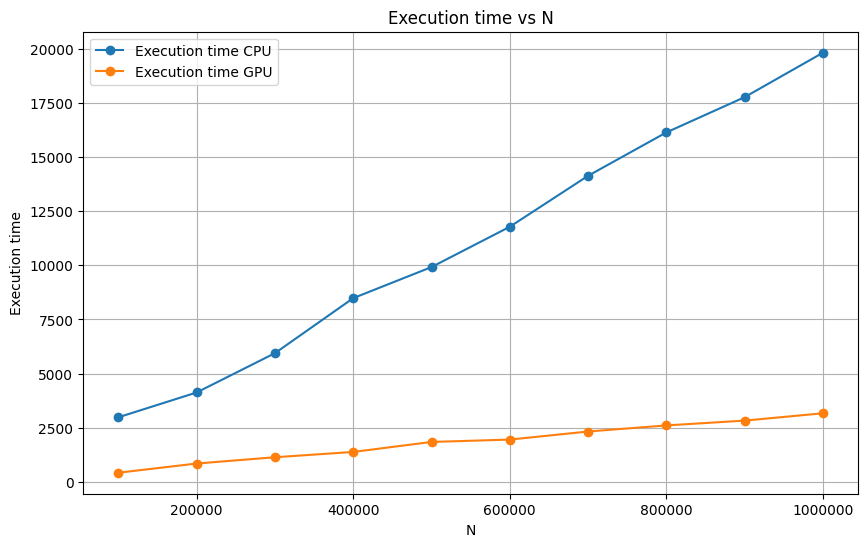

In [ ]:
# Graficar los datos
plt.figure(figsize=(10, 6))
plt.plot(df['N'], df['execution_time_cpu'], label='Execution time CPU', marker='o')
plt.plot(df['N'], df['execution_time_gpu'], label='Execution time GPU', marker='o')
plt.xlabel('N')
plt.ylabel('Execution time')
plt.title('Execution time vs N')
plt.ticklabel_format(style='plain', axis='x')
plt.legend()
plt.grid(True)
plt.show()

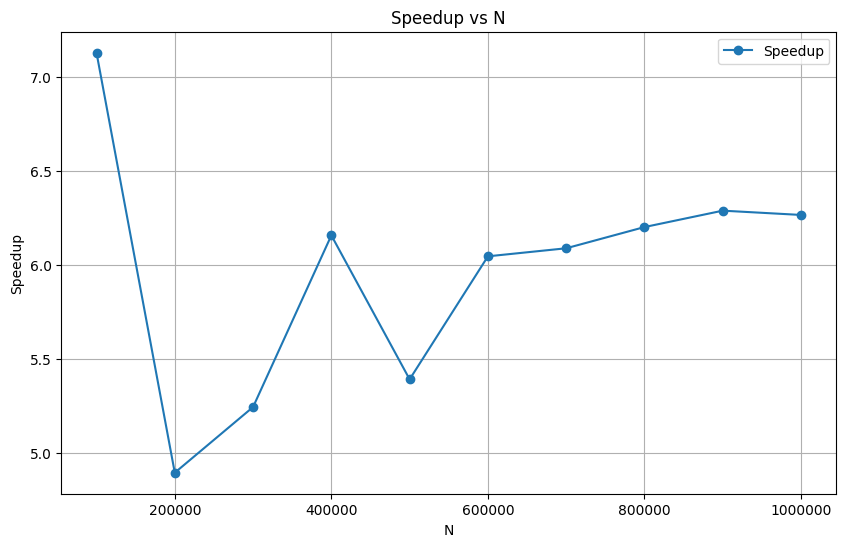

In [ ]:
# Graficar los datos
plt.figure(figsize=(10, 6))
plt.plot(df['N'], df_speedup['speedup'], label='Speedup', marker='o')
plt.xlabel('N')
plt.ticklabel_format(style='plain', axis='x')
plt.ylabel('Speedup')
plt.title('Speedup vs N')
plt.legend()
plt.grid(True)
plt.show()